Eleanor Gallay

June 18, 2024

This notebook creates MOC files of planet transit zones to make watchmaps on the Lasair Alert Broker. Code is adapted from the module "Transit Zones" https://github.com/ExoRob/Transit-Zones
doi:10.1093/mnras/stx2077

In [1]:
%matplotlib notebook
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import Angle, SkyCoord
from mocpy import MOC, WCS
import numpy as np
import matplotlib.cm as cm
import os
from scipy.optimize import curve_fit
import pandas

/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


> Fitting curves to data. (dens = 1)


<IPython.core.display.Javascript object>


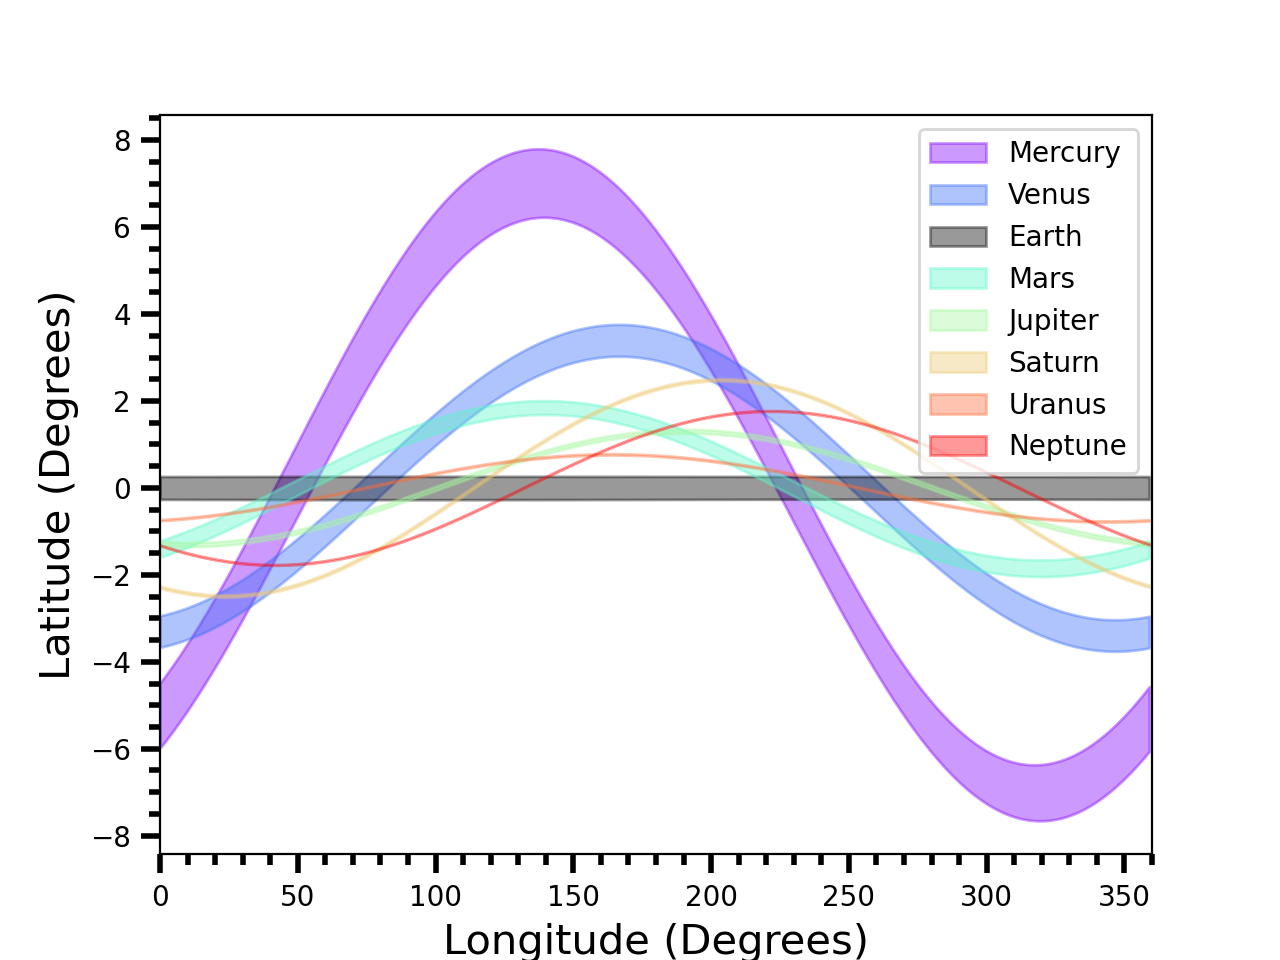

> Transit zones plot saved to "FigOut/AllHelioEcliptic.pdf".


In [2]:
# This cell is mostly code pulled from "Transit Zones" to calculate and plot transit zone angles. 
# I added arrays, long, uppertz, and lowertz, to be filled with ecliptic latitude and longitude 
# coordinates for the transit zones. 


outdirs = ['FigOut', 'DataOut']
datadirs = ['DataIn', 'DataOut']
for directory in outdirs:         # create output directories if not present
    if not os.path.exists(directory):
        os.makedirs(directory)
pandas.set_option('chained_assignment', None)   # turn off pandas copy warning

def TZ_calc(R_p, a, R_s):
    """
    Calculates the transit zone angle
    :param R_p: Planetary radius
    :param a: Sun-planet distance
    :param R_s: Solar radius
    :return: Transit zone angle
    """
    return np.degrees(2.0 * (np.arctan(R_s / a) - np.arcsin(R_p / np.sqrt(a*a + R_s*R_s))))


def graze_calc(R_p, a, R_s):            # calculates grazing angle
    return np.degrees(2.0 * np.arctan((R_p + R_s) / a))


def approx_TZ_calc(a, R_s):
    return np.degrees(2.0 * R_s / a)


def fit(x, A, d):                       # fits sine curve
    x = np.radians(x)

    return A * np.sin(x - d)


def fit2(x, A, d, c):                   # fits sine curve + offset
    x = np.radians(x)

    return A * np.sin(x - d) + c

dens = 1                  # number of data points / degree in fits (originally =400)
eq = 't'                    # run crossover code for transit zone angle, approximation or grazing angle ('t', 'a', 'g')
comp_region = [4, 5]        # regions to plot in comparison, 0:Mercury - 7:Neptune
plot_cs = [0, 2]            # which angles to compare - 0:transit zone, 1:approximation, 2:grazing


"""Loads planetary data and compute angles"""

# data from http://solarsystem.nasa.gov/planets/
au = 149597870700.0 / 1000.0    # 1 AU (km)
R_sun = 695508.0                # Radius of Sun (km)
names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']     # names of planets
radii = [2.4397E3, 6.0518E3, 6.3710E3, 3.3895E3, 6.9911E4, 5.8232E4, 2.5362E4, 2.4622E4]    # radii of planets
s_d = [57.909227E6, 1.0820948E8, 1.4959826E8, 2.2794382E8, 7.7834082E8, 1.4266664E9,        # semi-major axis
       2.8706582E9, 4.4983964E9]

colors = cm.rainbow(np.linspace(0, 1, len(names)))              # range of colours for plotting
cols = ['darkmagenta', 'darkolivegreen', 'darkgoldenrod']       # colours for plotting

sun_distances = []          # Sun-planet distances over 1 complete orbit from JPL Horizons
for i in range(len(names)):
    a = np.genfromtxt('OrbitData/ecl_helio_'+names[i]+'.txt', delimiter=',', skip_header=34, skip_footer=50)[:, 8]
    sun_distances.append(a)

psi_TZ = []             # transit zone angle
graze = []              # grazing angle
transit_depth = []      # transit depth
psi_TZ_ar = []          # variable transit zone angle over 1 orbit
graze_ar = []           # variable grazing angle over 1 orbit
approx_ar = []          # variable approximated angle over 1 orbit
for i in range(len(names)):
    R = radii[i]                # planetary radius
    d = sun_distances[i]        # semi-major axis

    # compute angles over 1 complete orbit
    approx_ar.append([])
    psi_TZ_ar.append([])
    graze_ar.append([])
    for j in range(len(d)):
        psi_TZ_ar[i].append(TZ_calc(R, d[j]*au, R_sun))
        approx_ar[i].append(approx_TZ_calc(d[j] * au, R_sun))
        graze_ar[i].append(graze_calc(R, d[j] * au, R_sun))

    psi = TZ_calc(R, s_d[i], R_sun)
    psi_TZ.append(psi)

    td = R**2 / R_sun**2
    transit_depth.append(td)

    grz = graze_calc(R, s_d[i], R_sun)
    graze.append(grz)

"""Loads JPL Horizons data and makes any needed files"""

# Load ecliptic data from JPL Horizons
ecl_lon_list, ecl_lat_list = [], []     # helio-centric ecliptic coordinates of the solar system planets over 1 orbit
for i in range(len(names)):
    ecl_lon_list.append(np.genfromtxt('OrbitData/ecl_helio_' + names[i] + '.txt', delimiter=',', skip_header=34,
                                      skip_footer=50)[:, 6])
    ecl_lat_list.append(np.genfromtxt('OrbitData/ecl_helio_' + names[i] + '.txt', delimiter=',', skip_header=34,
                                      skip_footer=50)[:, 7])

    """Fits sinusoidal curves to the ecliptic coordinates and variable angles over 1 complete orbit
   The parameter 'dens' gives the density of the curves. I.e. 'dens' datapoints per degree"""

print ('> Fitting curves to data. (dens = ' + str(dens) + ')')
data_fits = []      # holds all fits to the coordinates
fit_params = []     # holds all parameters of each fit
psi_fits = []       # transit zone angle
psi_params = []
graze_fits = []     # grazing angle
graze_params = []
approx_fits = []    # approximate angle
approx_params = []


fig = plt.figure()      # initialise figure
ax = fig.add_subplot(111)
plt.minorticks_on()

long = []          # to be filled with range of ecliptic longitude coordinates 
                   #for each planet (in degrees)

uppertz = []       # to be filled with range of ecliptic latitude coordinates 
                   # of upper transit zone boundary for each planet (in degrees)

lowertz = []       # to be filled with range of ecliptic longitude coordinates 
                   # of lower transit zone boundary for each planet (in degrees)

for i in range(len(names)):
    popt1, pcov1 = curve_fit(fit, ecl_lon_list[i], ecl_lat_list[i])     # fit coordinates to sine curve
    fit_params.append(popt1)

    popt2, pcov2 = curve_fit(fit2, ecl_lon_list[i], psi_TZ_ar[i])       # transit zone angle
    psi_params.append(popt2)

    popt3, pcov3 = curve_fit(fit2, ecl_lon_list[i], graze_ar[i])        # grazing angle
    graze_params.append(popt3)

    popt4, pcov4 = curve_fit(fit2, ecl_lon_list[i], approx_ar[i])       # approximate angle
    approx_params.append(popt4)

    data_fit = []
    psi_fit = []
    graze_fit = []
    approx_fit = []
    x_fit = []      # longitude for fit

    for j in range(360 * dens):
        data_fit.append(fit(j / float(dens), popt1[0], popt1[1]))
        psi_fit.append(fit2(j / float(dens), popt2[0], popt2[1], popt2[2]))
        graze_fit.append(fit2(j / float(dens), popt3[0], popt3[1], popt3[2]))
        approx_fit.append(fit2(j / float(dens), popt4[0], popt4[1], popt4[2]))
        x_fit.append(j / float(dens))

    approx_fits.append(approx_fit)
    psi_fits.append(psi_fit)
    data_fits.append(data_fit)
    graze_fits.append(graze_fit)

    if i != 2:          # colours on plot - Earth as black
        c = colors[i]
    else:
        c = 'black'
    df1 = data_fit + np.asarray(psi_fits[i]) / 2.0      # upper transit zone boundary
    df2 = data_fit - np.asarray(psi_fits[i]) / 2.0      # lower transit zone boundary

        # sample boundaries for smaller filesize of plot
    x_fit_c, df1_c, df2_c = [], [], []
    for k in range(0, len(x_fit)):
        x_fit_c.append(x_fit[k])
        df1_c.append(df1[k])
        df2_c.append(df2[k])
    x_fit_c, df1_c, df2_c = np.asarray(x_fit_c), np.asarray(df1_c), np.asarray(df2_c)

    ax.fill_between(x_fit_c, df1_c, df2_c, where=df1_c >= df2_c, edgecolor=c, 
                    facecolor=c, alpha=0.4, interpolate=True, label=names[i])      # plot zones as coloured bands
    
    
    long.append(x_fit)
    uppertz.append(df1)
    lowertz.append(df2)  #appending coordinates to empty arrays
    
figname = 'FigOut/AllHelioEcliptic.pdf'

ax.set_xlabel('Longitude (Degrees)', fontsize=15)
ax.set_ylabel('Latitude (Degrees)', fontsize=15)
ax.set_xlim(0.0, 360.0)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.tick_params(axis='both', which='both', width=2)
plt.tick_params(axis='both', which='major', length=7)
plt.tick_params(axis='both', which='minor', length=4)
ax.legend(loc=1)


plt.savefig(figname, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)
print ('> Transit zones plot saved to \"'+figname+'\".')

<IPython.core.display.Javascript object>


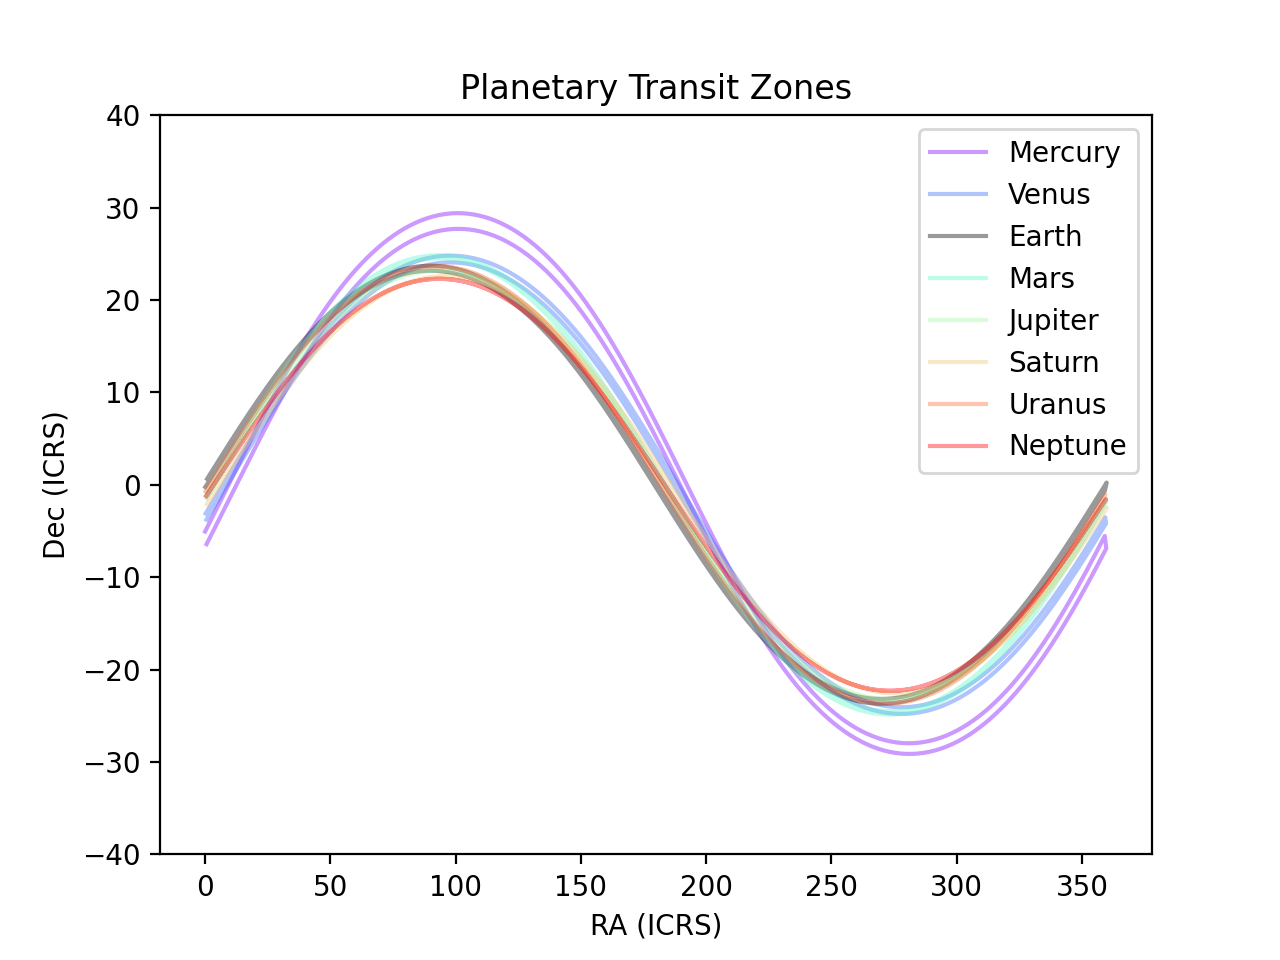

In [3]:
# Now we transform from ecliptic to celestial coordinates and plot RA and DEC of transit zones.

# this process is adapted from https://github.com/jradavenport/SETI_Alerts.git and 
# https://cds-astro.github.io/mocpy/examples/user_documentation.html#create-a-moc-from-a-concave-polygon



plt.figure()

for i in range(len(names)):
    ecoord1 = SkyCoord(np.array(long)[i,:] * u.deg, np.array(uppertz)[i,:] * u.deg, 
                   distance= np.ones(np.size(np.array(uppertz)[i,:])) * u.kpc, frame='heliocentrictrueecliptic')
    ecoord2 = SkyCoord(np.array(long)[i,:] * u.deg, np.array(lowertz)[i,:] * u.deg, 
                   distance= np.ones(np.size(np.array(lowertz)[i,:])) * u.kpc, frame='heliocentrictrueecliptic')
    icrs1 = ecoord1.icrs
    icrs2 = ecoord2.icrs

    sort1 = np.argsort(icrs1.ra.deg)
    sort2 = np.argsort(icrs2.ra.deg)[::-1]

    icrs = SkyCoord(np.append(icrs1.ra.deg[sort1], icrs2.ra.deg[sort2]) * u.deg,
                np.append(icrs1.dec.deg[sort1], icrs2.dec.deg[sort2]) * u.deg, frame='icrs')

    
    if i != 2:          # colors on plot - Earth as black
        c = colors[i]
    else:
        c = 'black'
 
    #plt.scatter(icrs.ra, icrs.dec)
    plt.plot(icrs.ra, icrs.dec, color=c, alpha=0.4, label=names[i])
    plt.xlabel('RA (ICRS)')
    plt.ylabel('Dec (ICRS)')
    plt.title('Planetary Transit Zones')
    plt.ylim(-40,40)
    plt.legend(loc=1)
    
    

   

saved Mercury MOC fits file


<IPython.core.display.Javascript object>


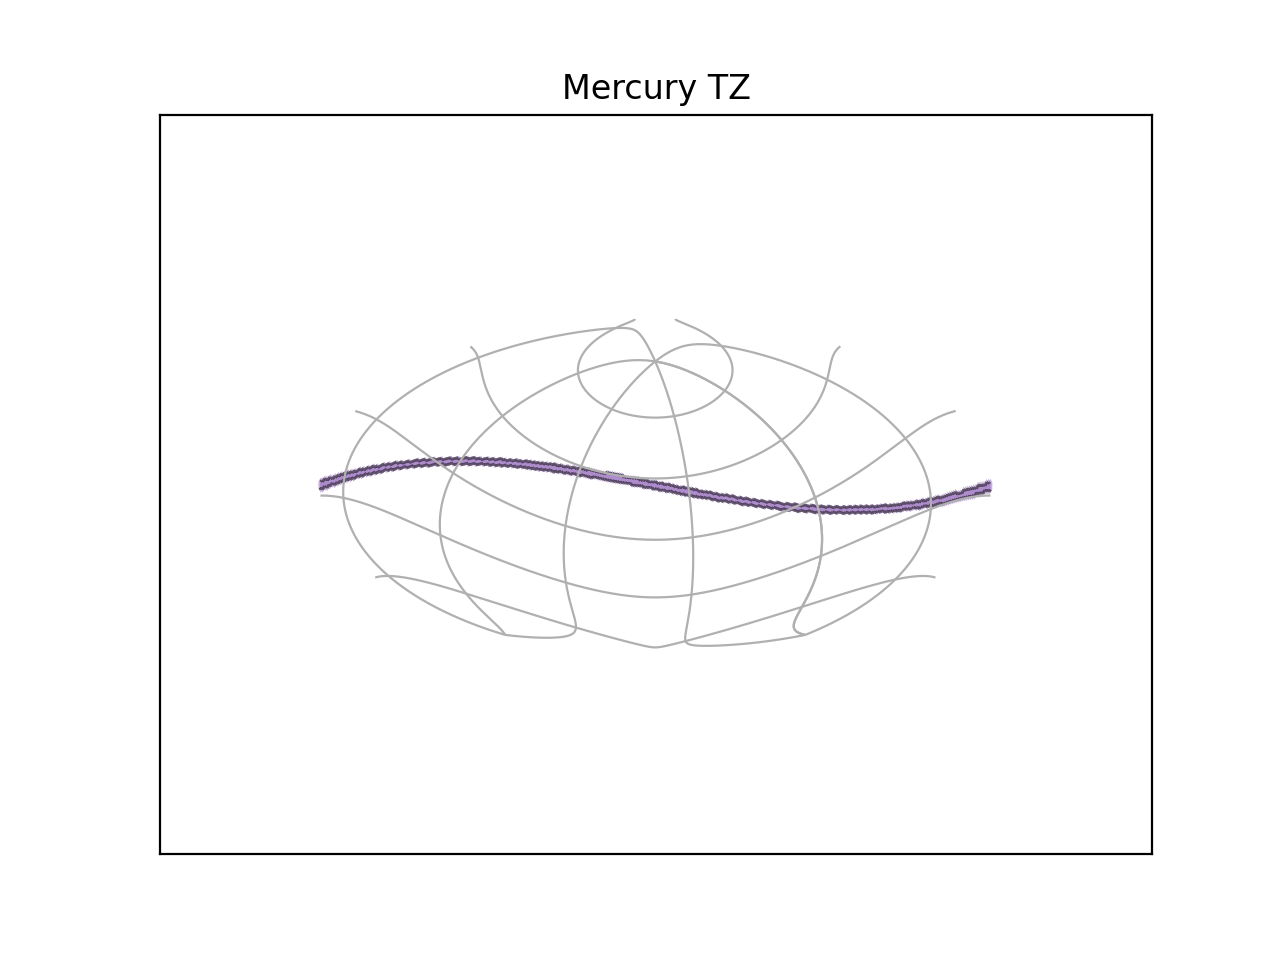

saved Venus MOC fits file


<IPython.core.display.Javascript object>


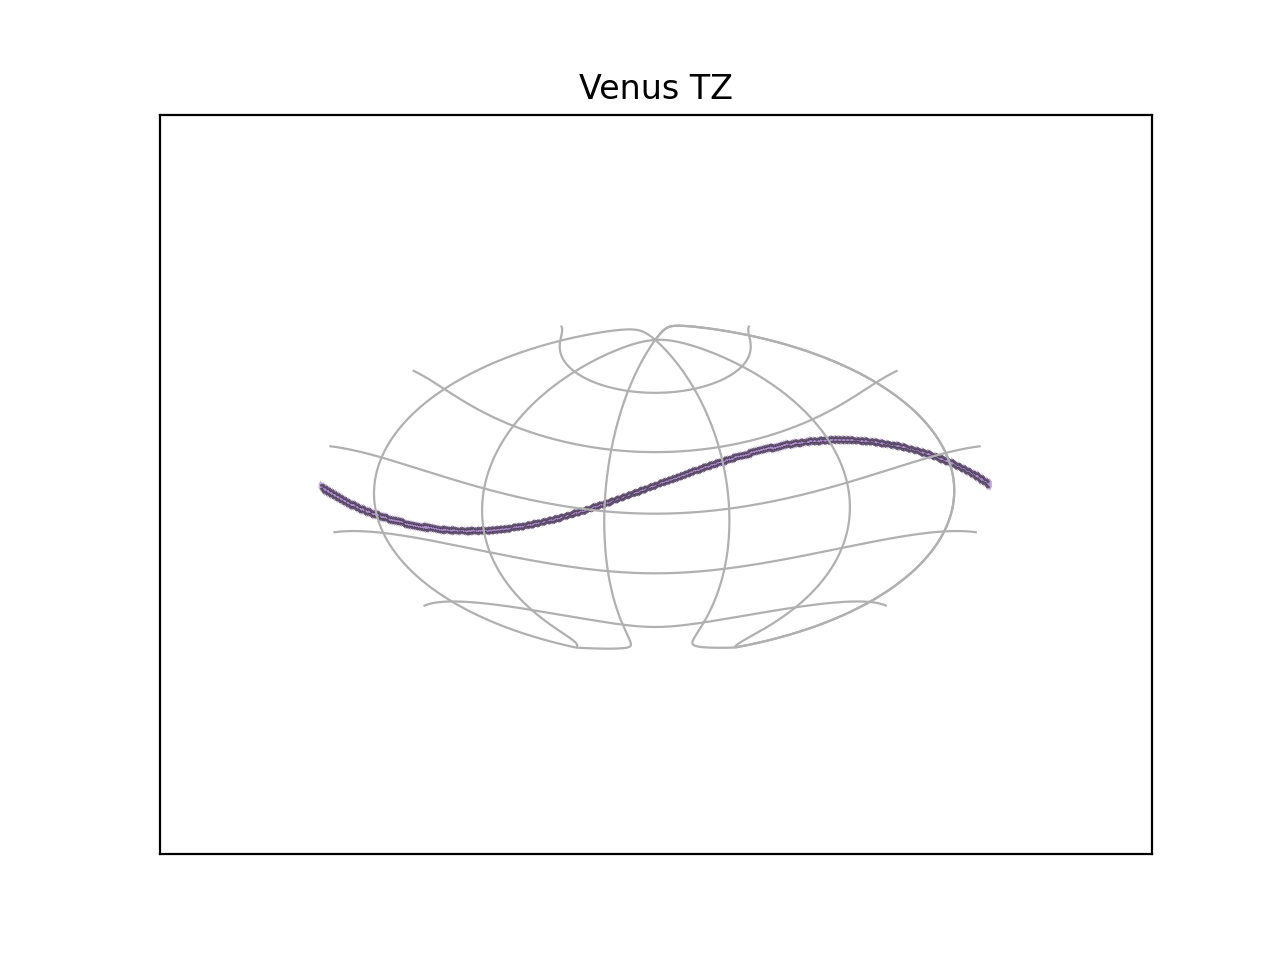

saved Earth MOC fits file


<IPython.core.display.Javascript object>


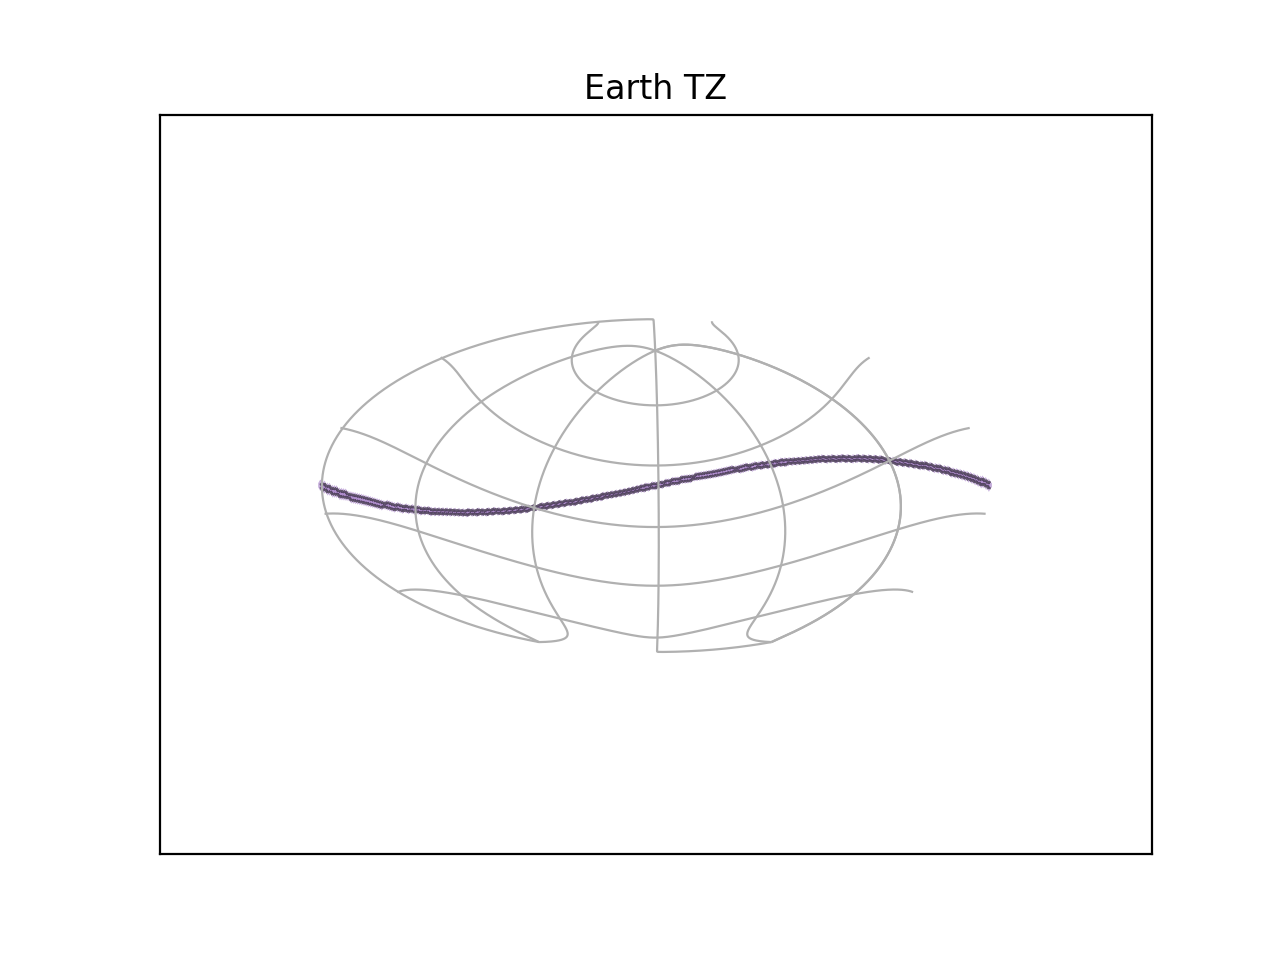

saved Mars MOC fits file


<IPython.core.display.Javascript object>


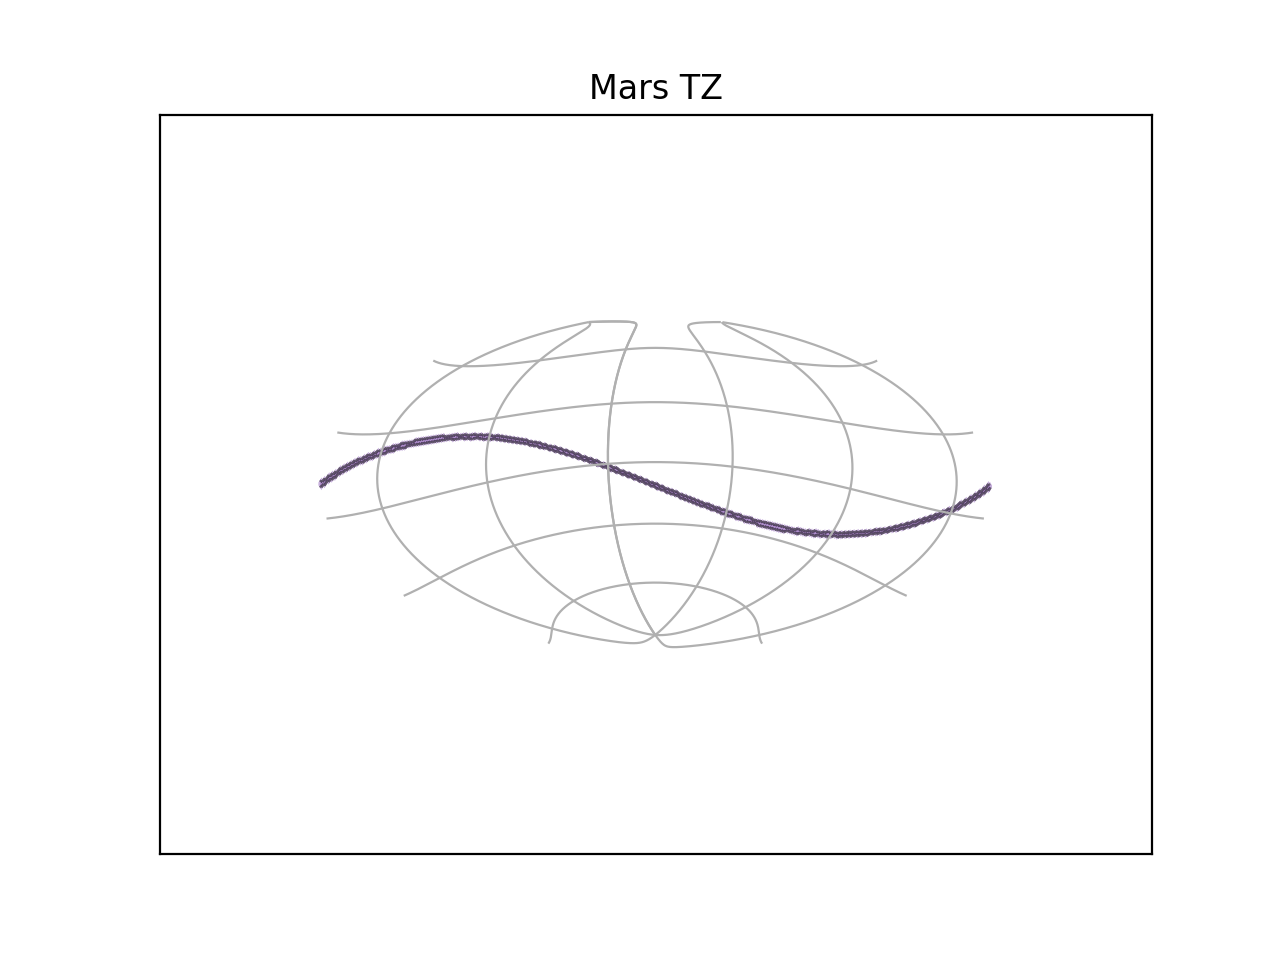

saved Jupiter MOC fits file


<IPython.core.display.Javascript object>


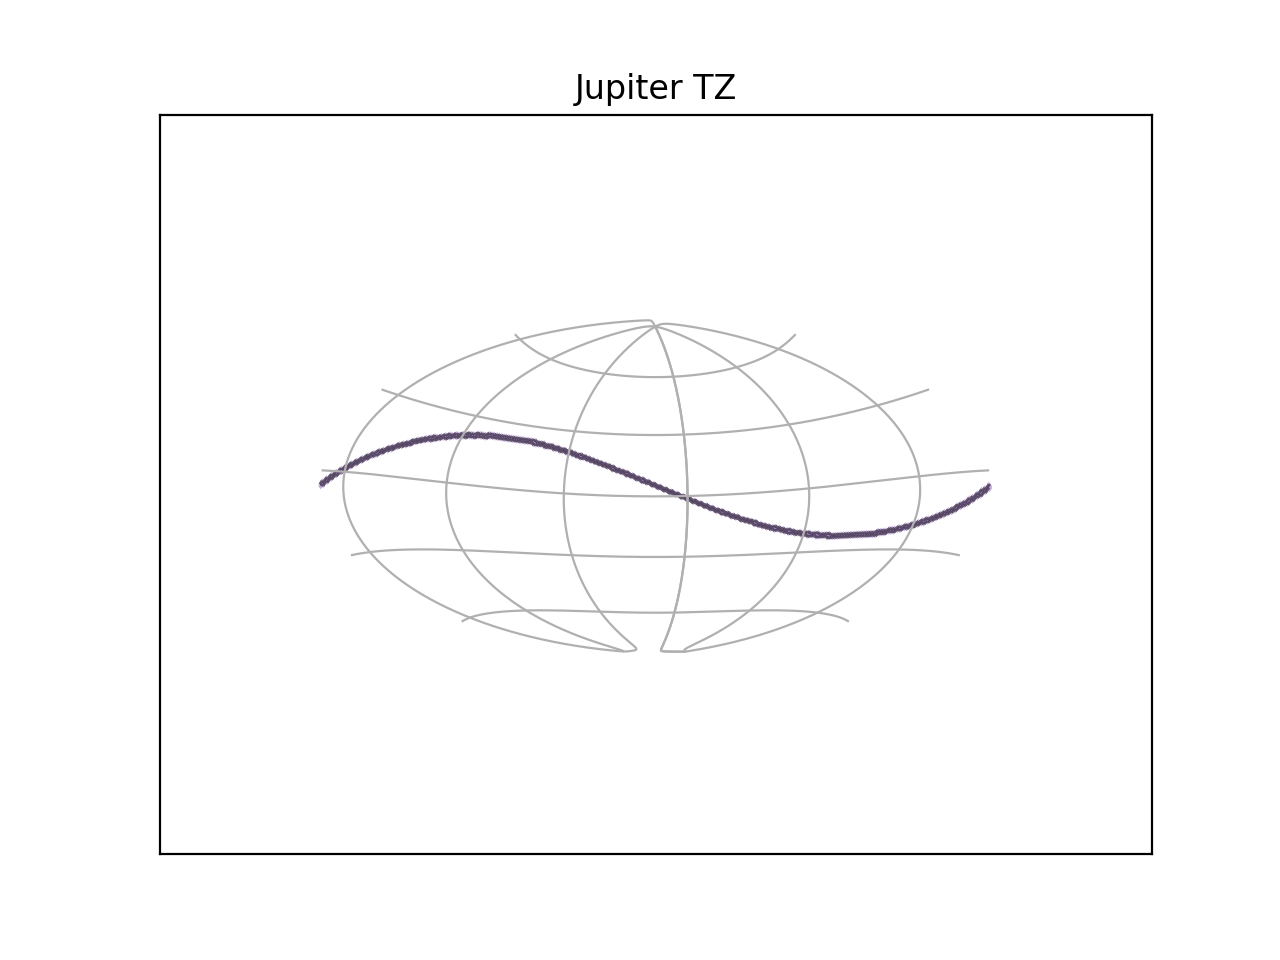

saved Saturn MOC fits file


<IPython.core.display.Javascript object>


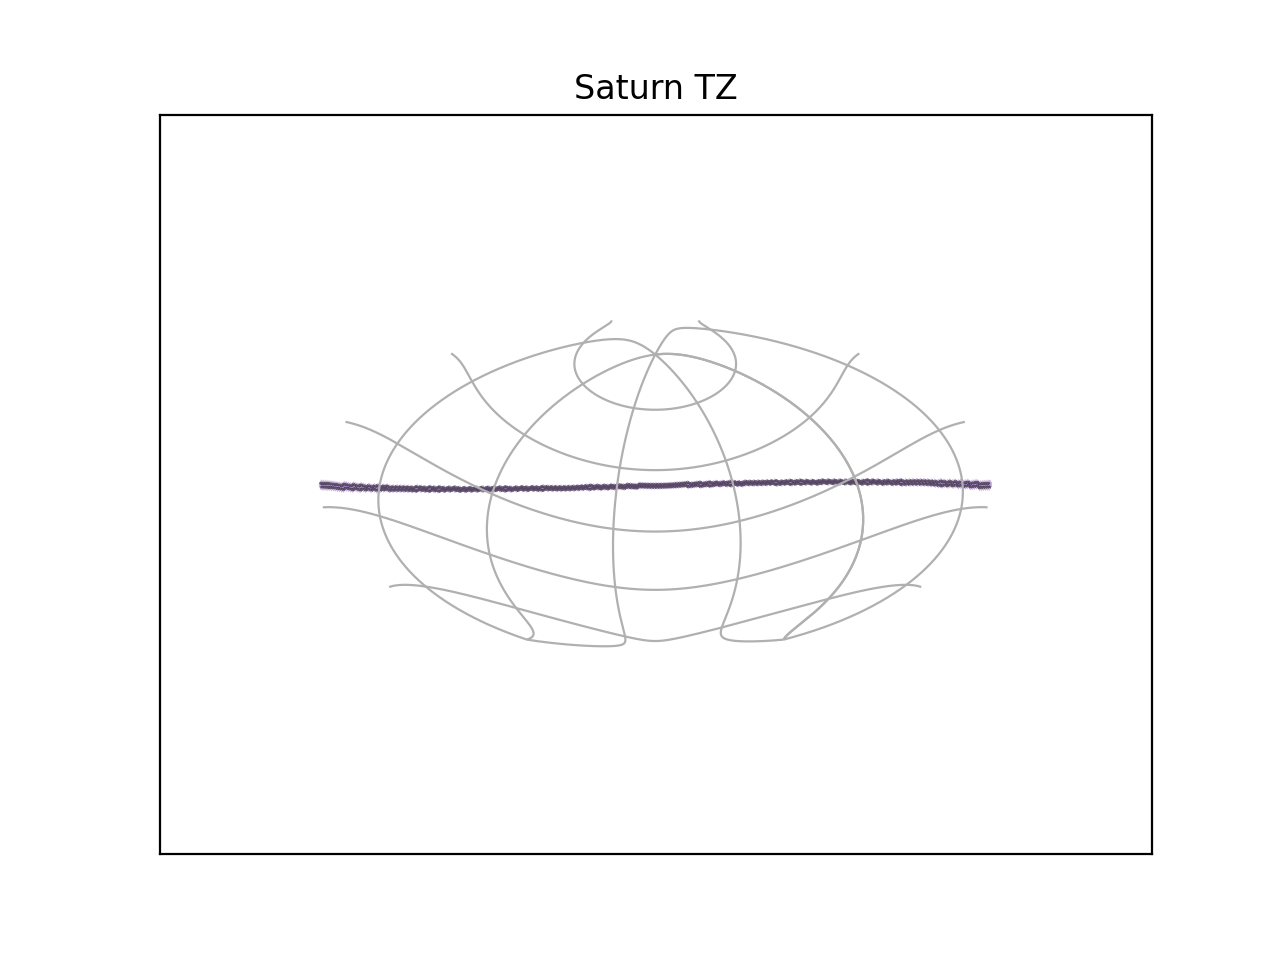

saved Uranus MOC fits file


<IPython.core.display.Javascript object>


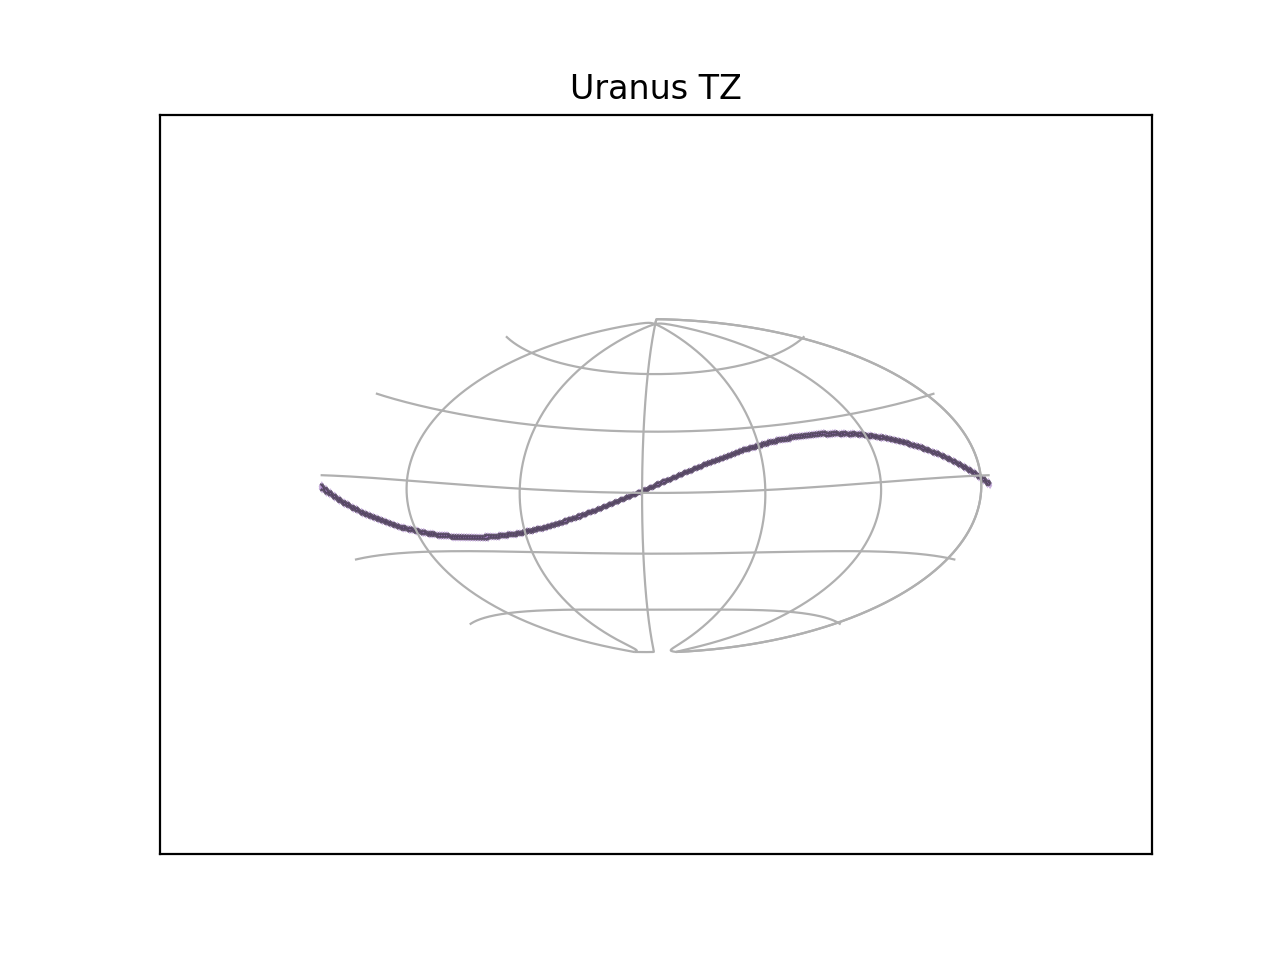

saved Neptune MOC fits file


<IPython.core.display.Javascript object>


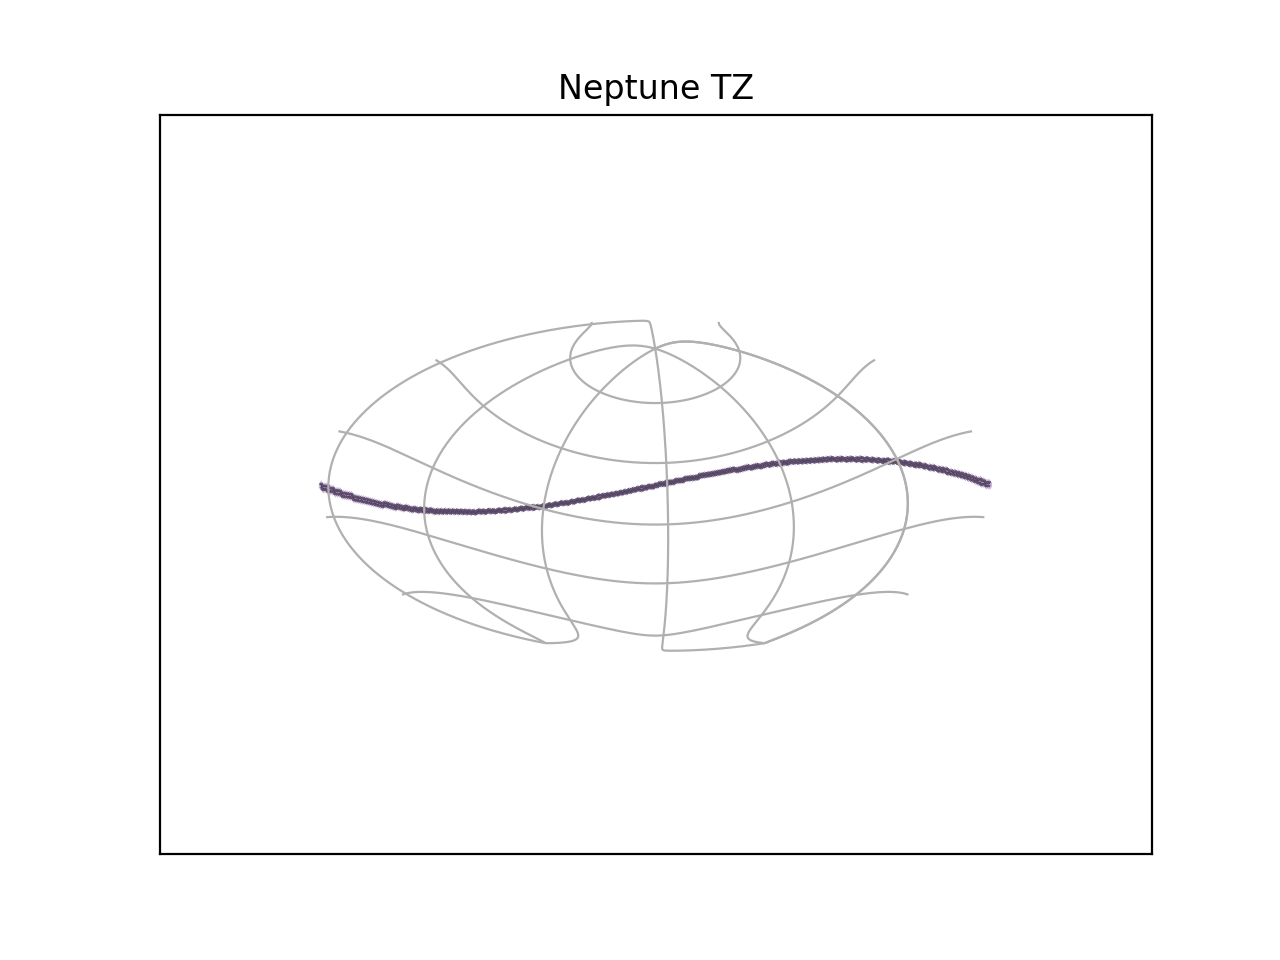

In [4]:
# Finally, we create a MOC file and plot the wcs for each planet.

for i in range(len(names)):
    
    ecoord1 = SkyCoord(np.array(long)[i,:] * u.deg, np.array(uppertz)[i,:] * u.deg, 
                   distance= np.ones(np.size(np.array(uppertz)[i,:])) * u.kpc, frame='heliocentrictrueecliptic')
    ecoord2 = SkyCoord(np.array(long)[i,:] * u.deg, np.array(lowertz)[i,:] * u.deg, 
                   distance= np.ones(np.size(np.array(lowertz)[i,:])) * u.kpc, frame='heliocentrictrueecliptic')
    icrs1 = ecoord1.icrs
    icrs2 = ecoord2.icrs

    sort1 = np.argsort(icrs1.ra.deg)
    sort2 = np.argsort(icrs2.ra.deg)[::-1]

    icrs = SkyCoord(np.append(icrs1.ra.deg[sort1], icrs2.ra.deg[sort2]) * u.deg,
                np.append(icrs1.dec.deg[sort1], icrs2.dec.deg[sort2]) * u.deg, frame='icrs')

    
    TZ = MOC.from_polygon_skycoord(icrs, max_depth=12)
    TZ.save(names[i] + "TZ_d12.fits", format="fits", overwrite=True)
    print('saved '+ names[i] + ' MOC fits file' )
    
    fig = plt.figure()
        
    wcs = TZ.wcs(fig, coordsys='icrs')  # automatically creates a wcs for the MOC
    ax1 = fig.add_subplot(111, projection=wcs)  # The first of a 2*2 grig of subplots

    TZ.fill(ax1, wcs, color="C4",alpha=0.5,)  # Where the MOC is added to the plot
    ax1.set_title(names[i]+ " TZ")

    TZ.border(ax=ax1, wcs=wcs, color="black", alpha=0.5)

    ax1.grid(True)

   